<a href="https://colab.research.google.com/github/Bharat-Moorthy/MLAI---Paathsalaassignments/blob/main/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!cp 'drive/My Drive/MLAI_part2/rsna-pneumonia-detection-challenge.zip' 'rsna-pneumonia-detection-challenge.zip'

In [2]:
ls

drive/  rsna-pneumonia-detection-challenge.zip  sample_data/


In [3]:
!unzip 'rsna-pneumonia-detection-challenge.zip'

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_trai

In [5]:
! pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.7 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pydicom as dcm
import math
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model

import cv2

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input 

import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence

import math

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnetProcess_input

In [4]:
labels = pd.read_csv("/content/stage_2_train_labels.csv")
labels.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [5]:
labels.shape

(30227, 6)

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [7]:
labels[labels.isnull().any(axis=1)].Target.value_counts()

0    20672
Name: Target, dtype: int64

In [8]:
## we can see that all the null column values are with Target 0 indicating that those patients do not have penumonia

In [9]:
labels[~labels.isnull().any(axis=1)].Target.value_counts()

1    9555
Name: Target, dtype: int64

In [10]:
## we can see that all the non null column values are with Target 1 indicating that those patients have pneumonia

In [11]:
labels.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [12]:
## Distubution of Targets , there are 20672 records with no pneumonia and 9555 with pneumonia

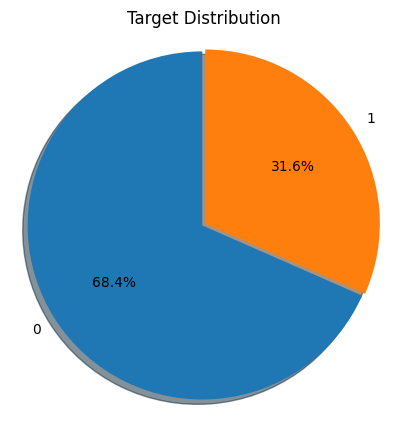

In [13]:
## Disturbution of Target, there are 31% of patients with pneumonia and the remaining are no pneumonia
## There is a class imbalance issue
label_count=labels['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

In [14]:
duplicateRowsDF = labels[labels.duplicated(['patientId'])]
duplicateRowsDF.shape

(3543, 6)

In [15]:
## There are 3543 duplicates

In [16]:
## Reading the classes label , 
class_labels = pd.read_csv('/content/stage_2_detailed_class_info.csv')
class_labels.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [17]:
class_labels.shape

(30227, 2)

In [18]:
class_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [19]:
class_labels['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [20]:
## there are 8851 normal cases , person with lung opactiry are 9555 and No Lung Opacity / Not Normal are 11821 

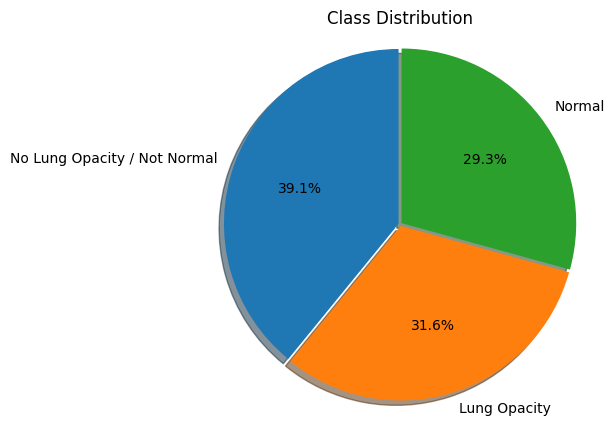

In [21]:

label_count=class_labels['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

In [22]:
## Disturbution of Classes, there are 39% of patients with No Lung opacity , 29.3% Normal 
## and the remaining are with Lung Opacity

In [23]:
duplicateClassRowsDF = class_labels[class_labels.duplicated(['patientId'])]
duplicateClassRowsDF.shape

(3543, 2)

In [24]:
## There are 3543 duplicates similar to the labels dataset

In [25]:
# Conctinating the two dataset - 'labels' and 'class_labels':
training_data = pd.concat([labels, class_labels['class']], axis = 1)

training_data.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

Text(0.5, 1.0, 'Class and Target  Distribution')

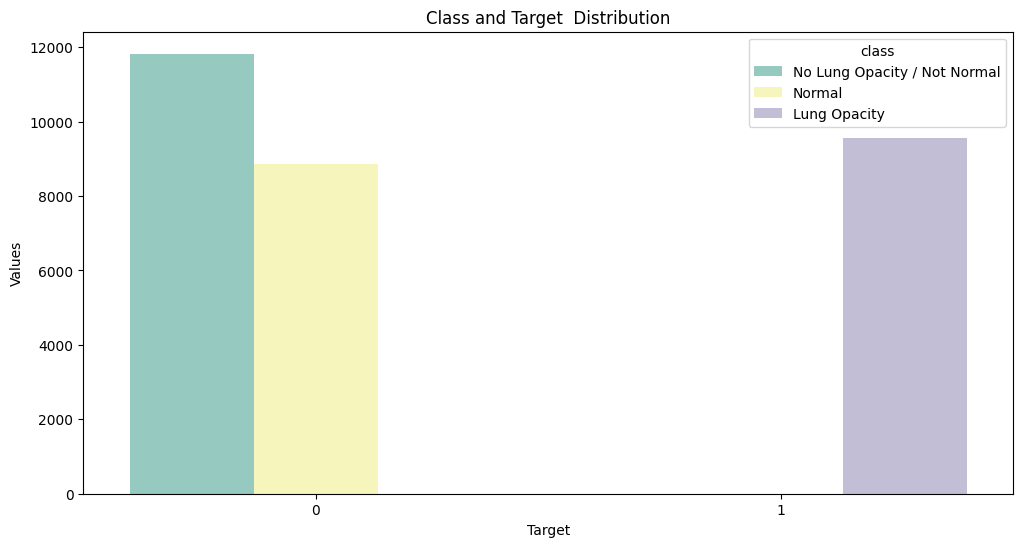

In [26]:
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'Set3')
plt.title('Class and Target  Distribution')

In [27]:
## it shows that class distrubution grouped by Target 
## Target 0 has only Normal or No Lung Opacity class
## Target 1 has only Lung Opacity class

In [28]:
## Analysing the dicom image
import matplotlib.patches as patches

def inspectImages(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        dcm_file = '/content/stage_2_train_images/'+'{}.dcm'.format(patientImage)
        data_row_img_data = dcm.read_file(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\Bounds: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
            ax[i//3, i%3].add_patch(rect)

    plt.show()

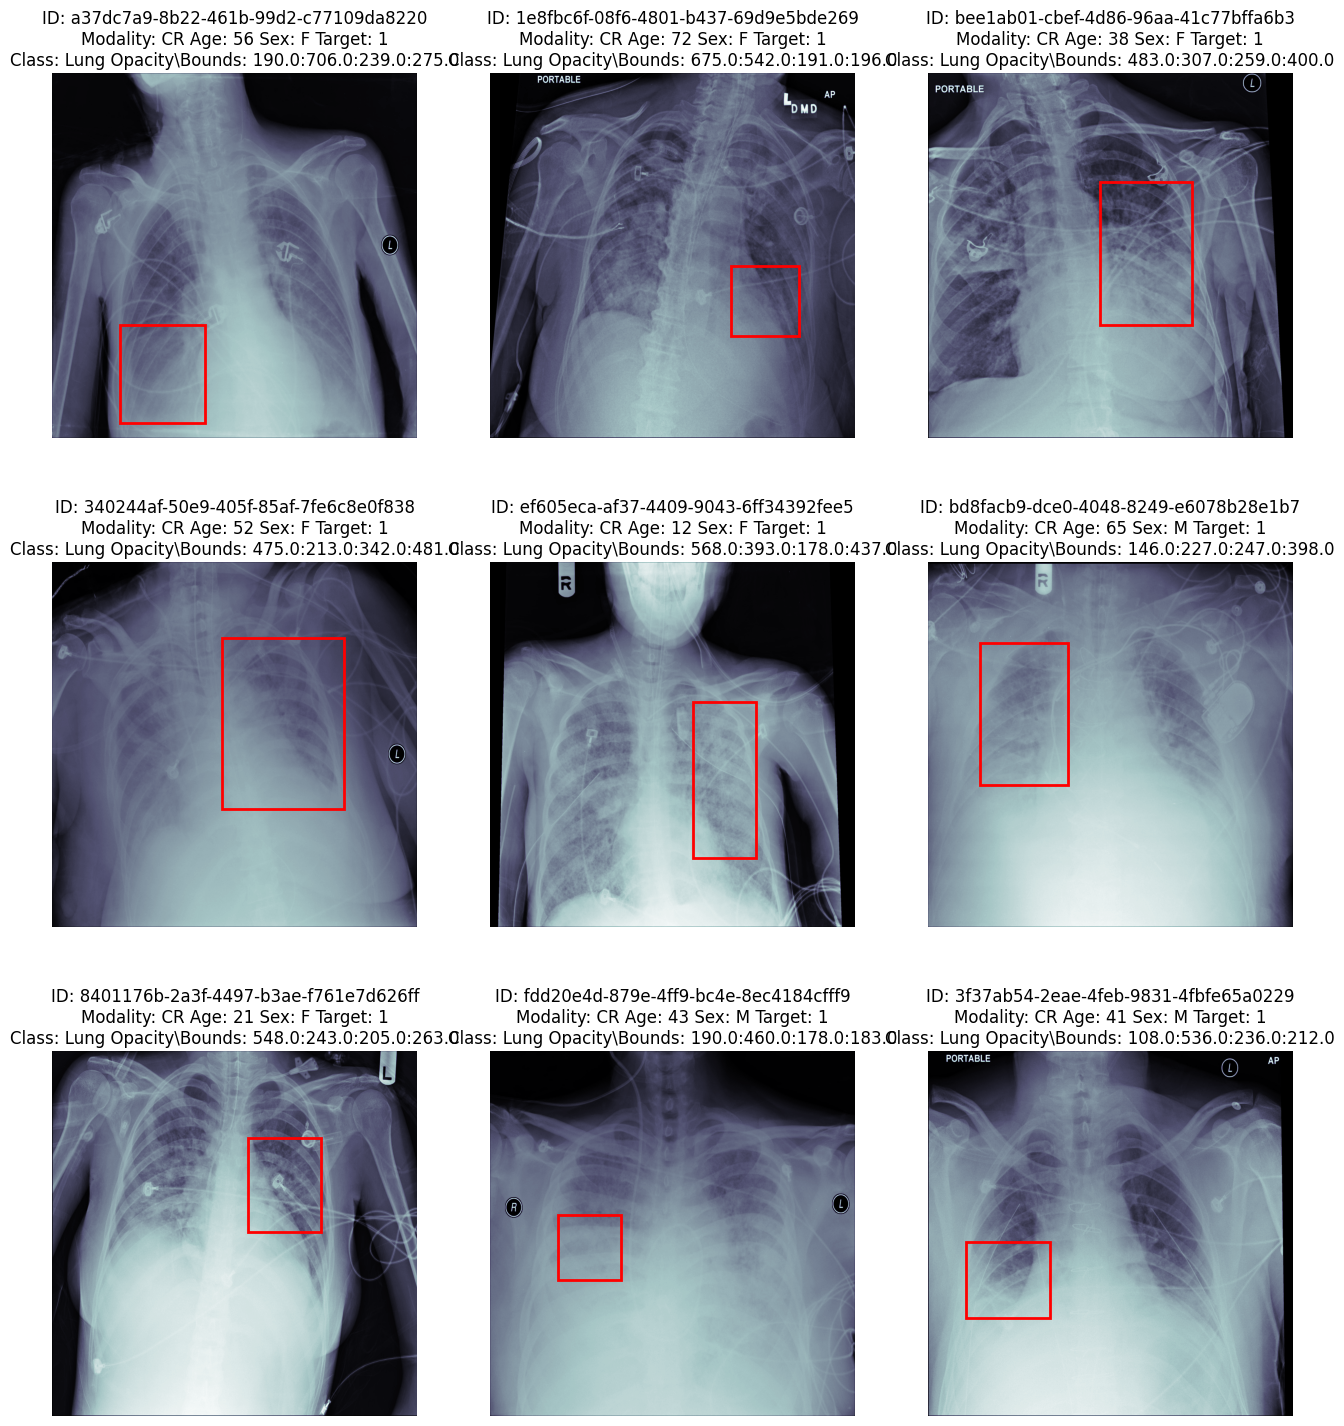

In [29]:
## checking few images which has pneumonia 
inspectImages(training_data[training_data['Target']==1].sample(9))

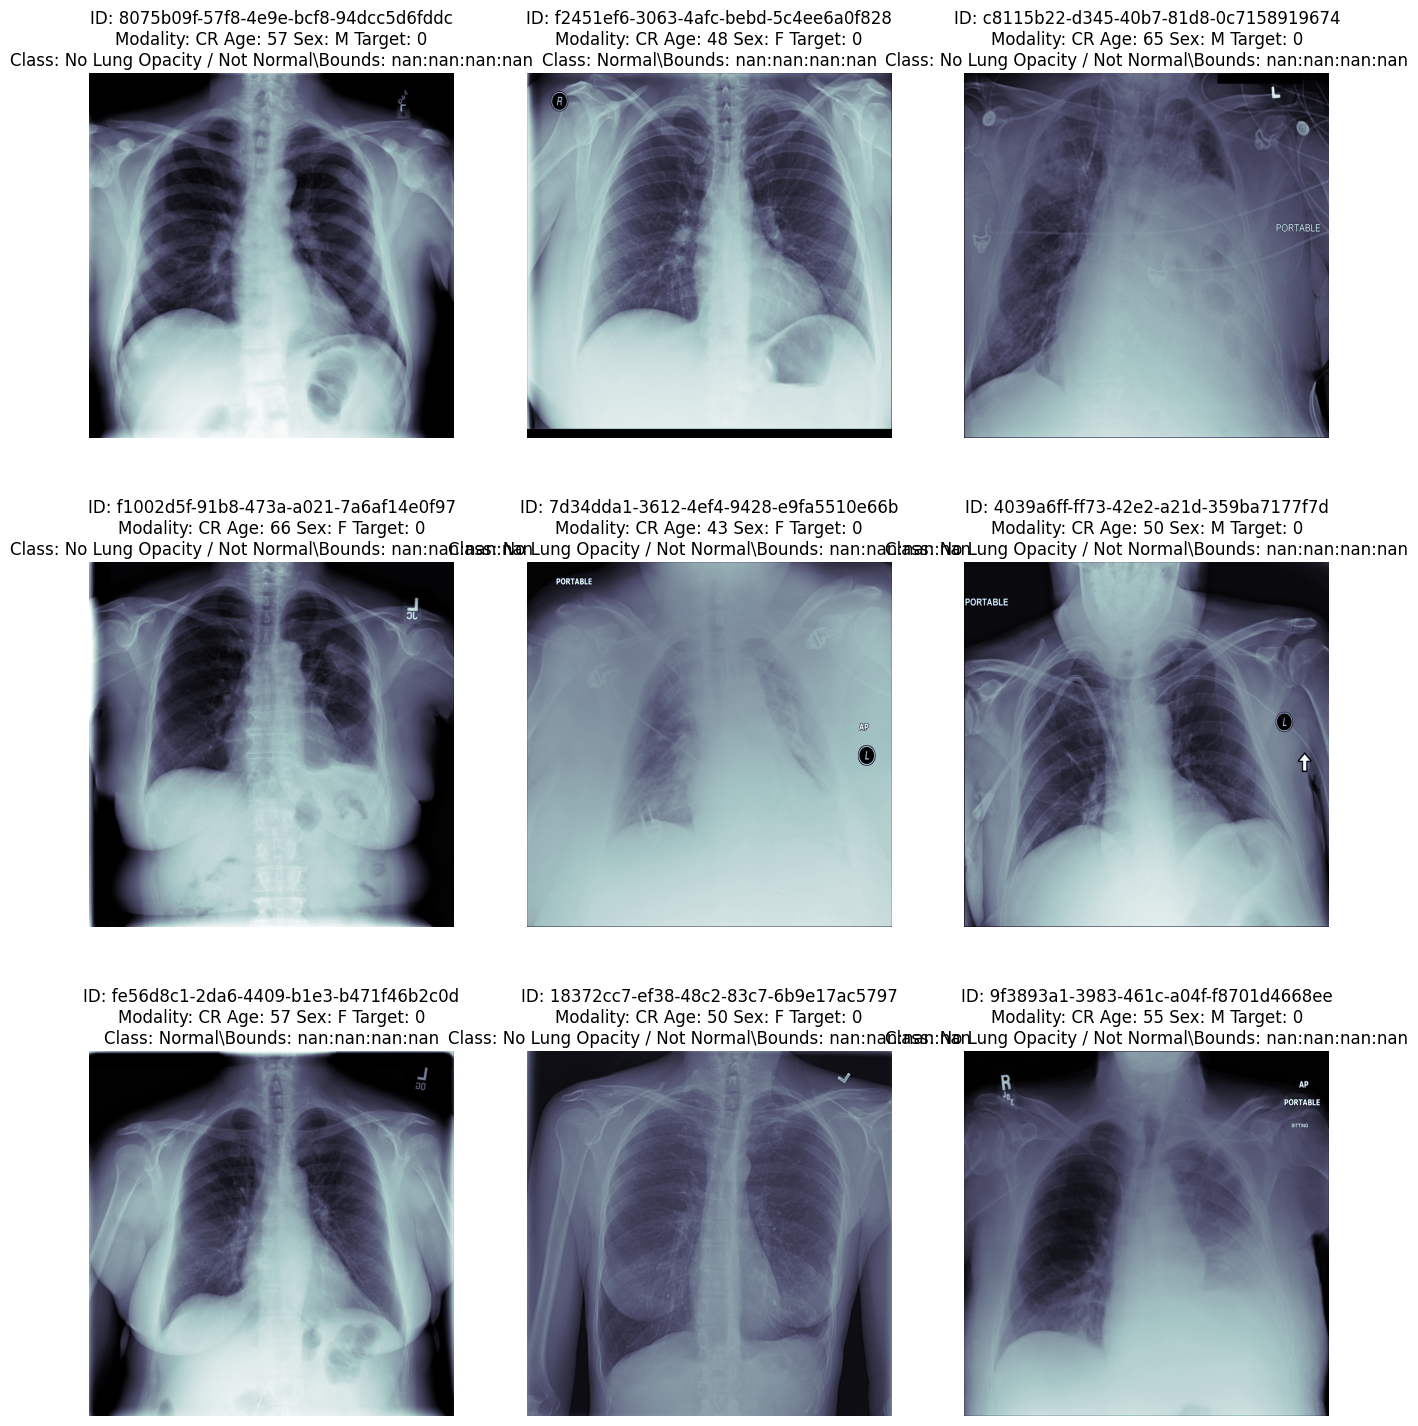

In [30]:
## checking few images which does not have pnemuonia 
inspectImages(training_data[training_data['Target']==0].sample(9))


In [31]:
def readDCIMData(rowData):
    dcm_file = '/content/stage_2_train_images/'+'{}.dcm'.format(rowData.patientId)
    dcm_data = dcm.read_file(dcm_file)
    img = dcm_data.pixel_array
    return dcm_data.PatientSex,dcm_data.PatientAge

In [32]:
## Reading the image data and append it to the training_data dataset
training_data['sex'], training_data['age'] = zip(*training_data.apply(readDCIMData, axis=1))

In [33]:
training_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
 7   sex        30227 non-null  object 
 8   age        30227 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 2.1+ MB


In [34]:
## There are 30227  records
## sex and age also have the smae count indicating that there are no images missing every patient has an dicom image 
## Age should be a numeric , currently it is an object

In [35]:
# Converting age to Numeric as the current data type is a String
training_data['age'] = training_data.age.astype(int)

In [36]:
training_data.describe(include="all").T

count unique                                   top   freq  \
patientId    30227  26684  3239951b-6211-4290-b237-3d9ad17176db      4   
x           9555.0    NaN                                   NaN    NaN   
y           9555.0    NaN                                   NaN    NaN   
width       9555.0    NaN                                   NaN    NaN   
height      9555.0    NaN                                   NaN    NaN   
Target     30227.0    NaN                                   NaN    NaN   
class        30227      3          No Lung Opacity / Not Normal  11821   
sex          30227      2                                     M  17216   
age        30227.0    NaN                                   NaN    NaN   

                 mean         std   min    25%    50%    75%    max  
patientId         NaN         NaN   NaN    NaN    NaN    NaN    NaN  
x          394.047724  204.574172   2.0  207.0  324.0  594.0  835.0  
y           366.83956  148.940488   2.0  249.0  365.0  478.5  881.0  
width      218.471376   59.289475  40.0  177.0  217.0  259.0  528.0  
height     329.269702  157.750755  45.0  203.0  298.0  438.0  942.0  
Target       0.316108    0.464963   0.0    0.0    0.0    1.0    1.0  
class             NaN         NaN   NaN    NaN    NaN    NaN    NaN  
sex               NaN         NaN   NaN    NaN    NaN    NaN    NaN  
age         46.797764    16.89294   1.0   34.0   49.0   59.0  155.0

In [37]:
## The mean age is 46 years , where as minimum age is 1 year and the max age is 155 which seems to be an outlier
## 50% of the patients are of aroudn 49 age , the std deviation is 16 which suggest that age is not normally distubuted

In [38]:
training_data.sex.value_counts()

M    17216
F    13011
Name: sex, dtype: int64

Text(0.5, 1.0, 'Sex and Target for Chest ')

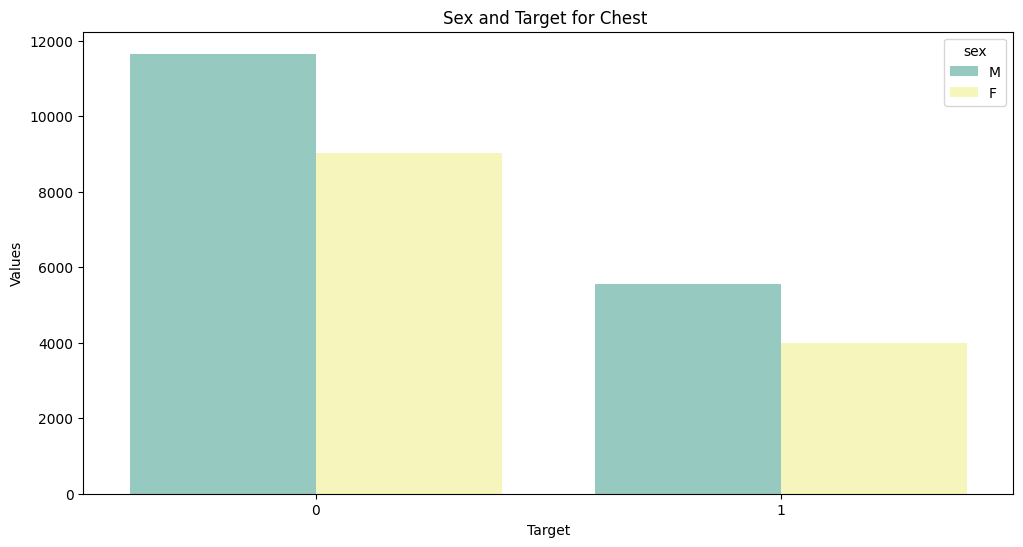

In [39]:
## Distbution of Sex Among the targets
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and Target for Chest ')

In [40]:
## the number of males in both category are higher than women

Text(0.5, 1.0, 'Sex and class for Chest ')

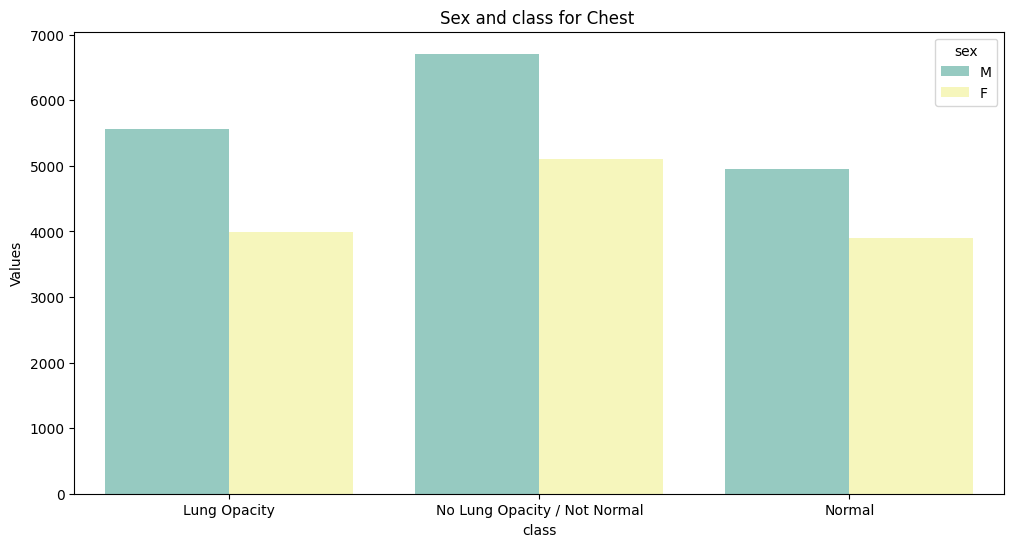

In [41]:
## Distbution of Sex Among the classes
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('class')['sex'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'class', y = 'Values', hue = 'sex', data = data_target_class, palette = 'Set3')
plt.title('Sex and class for Chest ')

In [42]:
## the number of males in all classes are higher than women

<Axes: xlabel='age', ylabel='Count'>

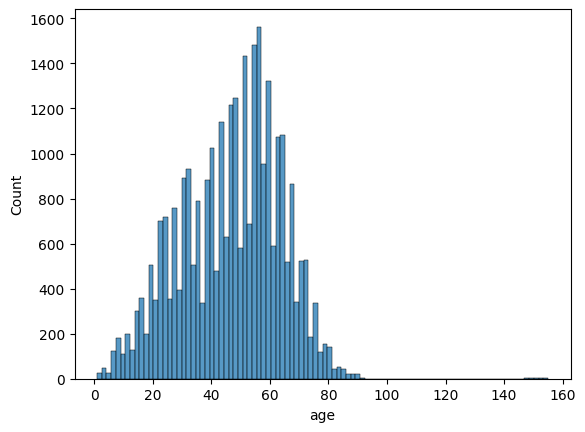

In [43]:
sns.histplot(training_data.age) 

In [44]:
# plots the distribution of age
## Looks closer to normal distubution of age

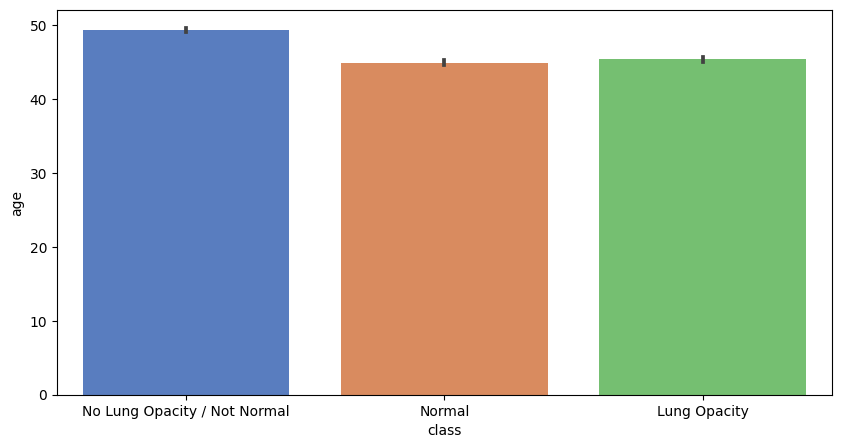

In [45]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='class', y='age', data=training_data, palette='muted')  # barplot'

In [46]:
## This is the distubution of Age with class, maximum age of person with pneuomina is arund 45

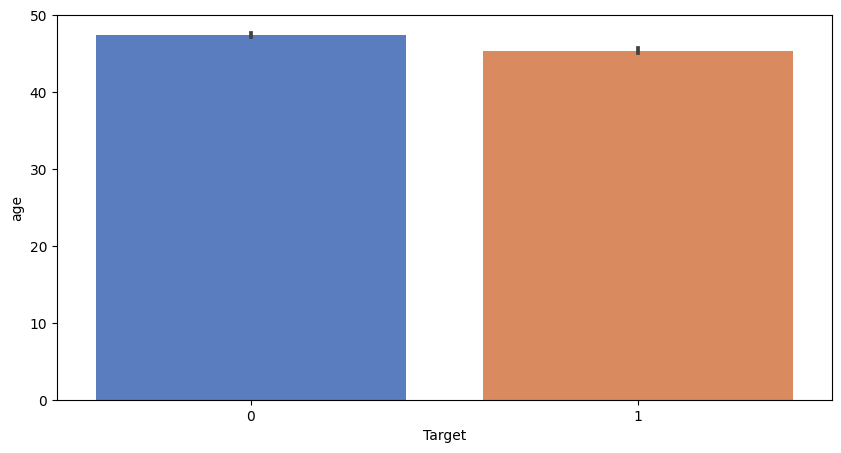

In [47]:
plt.figure(figsize=(10,5))  # setting the figure size
ax = sns.barplot(x='Target', y='age', data=training_data, palette='muted')  # barplot'

In [48]:
## This is the distubution of Age with class, maximum age of person with pneuomina is arund 45

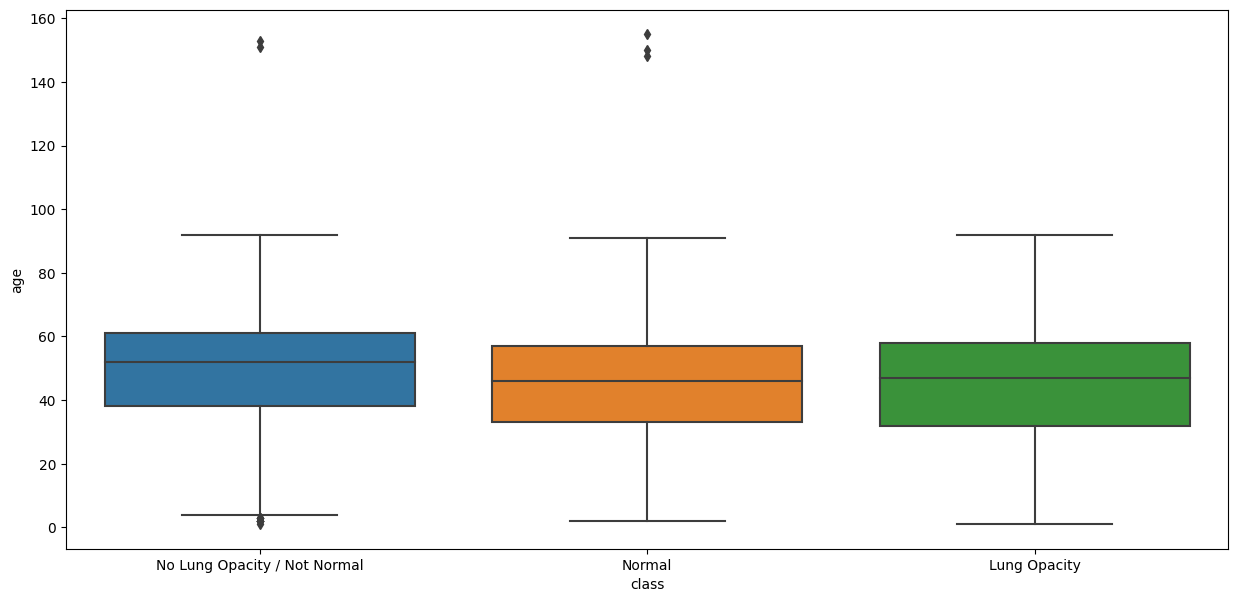

In [49]:
plt.figure(figsize=(15,7))
sns.boxplot(x='class', y='age', data= training_data)
plt.show()

In [50]:
## The  class which has no pneuomia has few outliers , their age is somewhere aroun 150 years

Distribution of `Age`: Overall and Target = 1


<ipython-input-51-6cca5a14410e>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = (sns.distplot(training_data['age']).set_title('Distribution of PatientAge'))
<ipython-input-51-6cca5a14410e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = (sns.distplot(training_data.loc[training_data['Target'] == 1, 'age']).set_t

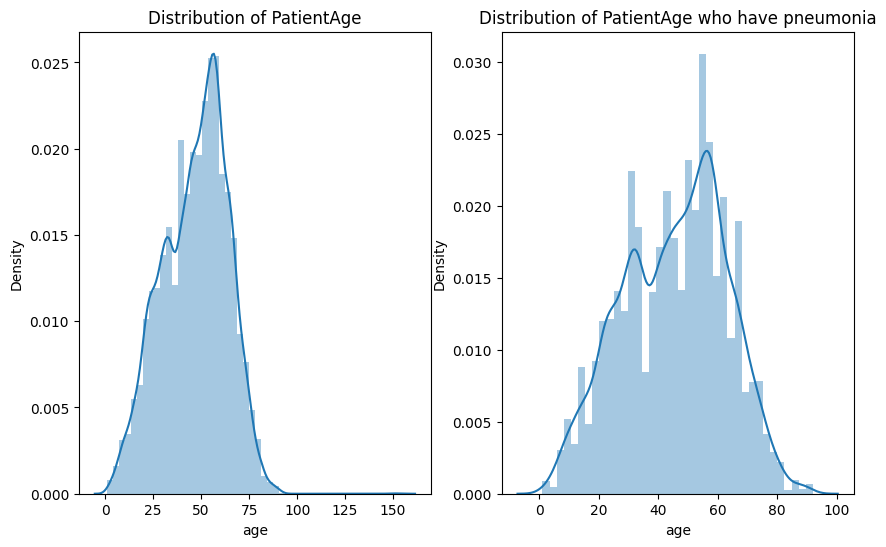

In [51]:
print('Distribution of `Age`: Overall and Target = 1')
fig = plt.figure(figsize = (10, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(training_data['age']).set_title('Distribution of PatientAge'))

ax = fig.add_subplot(122)
g = (sns.distplot(training_data.loc[training_data['Target'] == 1, 'age']).set_title('Distribution of PatientAge who have pneumonia'))

<Axes: >

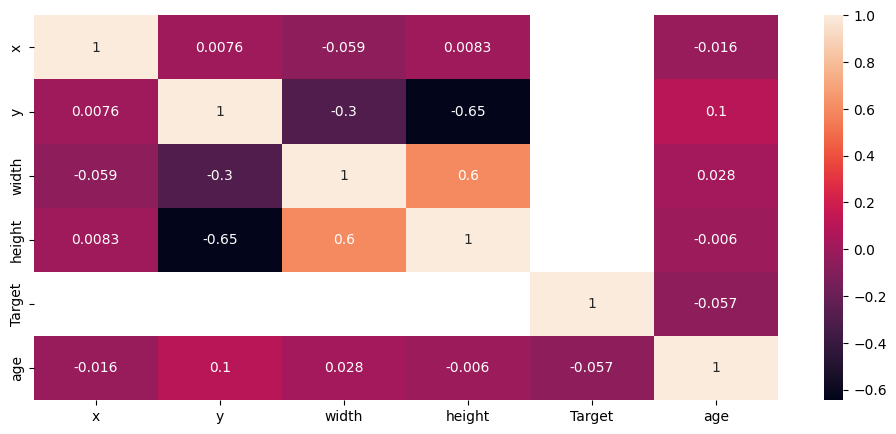

In [52]:
corr = training_data.corr()
plt.figure(figsize=(12,5))

sns.heatmap(corr,annot=True)

In [53]:
## There is higher corelation between width and height

In [54]:
#Model Building
## Just taking a 200 samples from the dataset

In [55]:
sample_trainigdata = training_data.groupby('class', group_keys=False).apply(lambda x: x.sample(800))

In [56]:
## Checking the training data set with class distbution 
sample_trainigdata["class"].value_counts()

Lung Opacity                    800
No Lung Opacity / Not Normal    800
Normal                          800
Name: class, dtype: int64

In [57]:
sample_trainigdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 19226 to 17357
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  2400 non-null   object 
 1   x          800 non-null    float64
 2   y          800 non-null    float64
 3   width      800 non-null    float64
 4   height     800 non-null    float64
 5   Target     2400 non-null   int64  
 6   class      2400 non-null   object 
 7   sex        2400 non-null   object 
 8   age        2400 non-null   int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 187.5+ KB


In [58]:
## Pre Processing the image
from tensorflow.keras.applications.mobilenet import preprocess_input

images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the image and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = '/content/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

In [59]:
## Reading the images into numpy array
images,labels = populateImage(sample_trainigdata)

In [60]:
images.shape , labels.shape
## The image is of 128*128 with 3 channels

((2400, 128, 128, 3), (2400,))

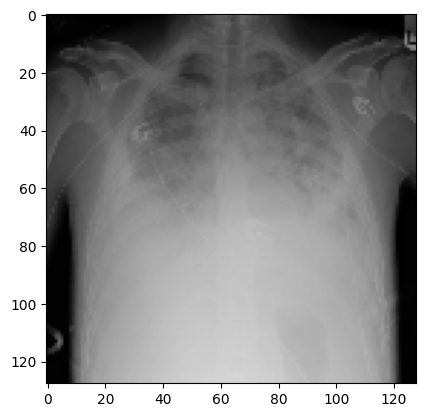

In [61]:
## Checking one of the converted image 
plt.imshow(images[100])

In [62]:
## check the unique labels
np.unique(labels),len(np.unique(labels))

(array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
       dtype='<U28'),
 3)

In [63]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
# define model
from tensorflow.keras import losses,optimizers
from tensorflow.keras.layers import Dense,  Activation, Flatten,Dropout,MaxPooling2D,BatchNormalization
import pandas as pd
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats 
import matplotlib.pyplot as plt
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from sklearn.model_selection import StratifiedKFold
%matplotlib inline
#Test Train Split
from sklearn.model_selection import train_test_split
#Feature Scaling library
from sklearn.preprocessing import StandardScaler
#import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense ,LeakyReLU
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [64]:
## encoding the labels
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y2 = enc.fit_transform(labels)

In [65]:
## splitting into train ,test and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

In [66]:
## FUnction to create a dataframe for results
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

In [67]:
## CNN Model without transfer learning , we start with 32 filters with 5,5 kernal and no padding , then 64 and 128 with drop layers in between 
## And softmax activaation as the last layer
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [68]:
# Model Summary
cnn = cnn_model(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

In [69]:
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 30, 
                  validation_data = (X_val,y_val),
                  batch_size = 30)

Epoch 1/30
56/56 [==============================] - 17s 66ms/step - loss: 3.4356 - accuracy: 0.3524 - val_loss: 1.0971 - val_accuracy: 0.3556
Epoch 2/30
56/56 [==============================] - 3s 55ms/step - loss: 1.1236 - accuracy: 0.3387 - val_loss: 1.0850 - val_accuracy: 0.4028
Epoch 3/30
56/56 [==============================] - 3s 53ms/step - loss: 1.0959 - accuracy: 0.3798 - val_loss: 1.0833 - val_accuracy: 0.3694
Epoch 4/30
56/56 [==============================] - 3s 55ms/step - loss: 1.1021 - accuracy: 0.3976 - val_loss: 1.0678 - val_accuracy: 0.4278
Epoch 5/30
56/56 [==============================] - 3s 54ms/step - loss: 1.0742 - accuracy: 0.4238 - val_loss: 1.0656 - val_accuracy: 0.4028
Epoch 6/30
56/56 [==============================] - 3s 55ms/step - loss: 1.0735 - accuracy: 0.4143 - val_loss: 1.0870 - val_accuracy: 0.3528
Epoch 7/30
56/56 [==============================] - 3s 55ms/step - loss: 1.1453 - accuracy: 0.4131 - val_loss: 1.0523 - val_accuracy: 0.3889
Epoch 8/30
5

In [70]:
fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

12/12 [==============================] - 1s 36ms/step - loss: 1.0065 - accuracy: 0.4944
Test loss: 1.0065454244613647
Test accuracy: 0.49444442987442017


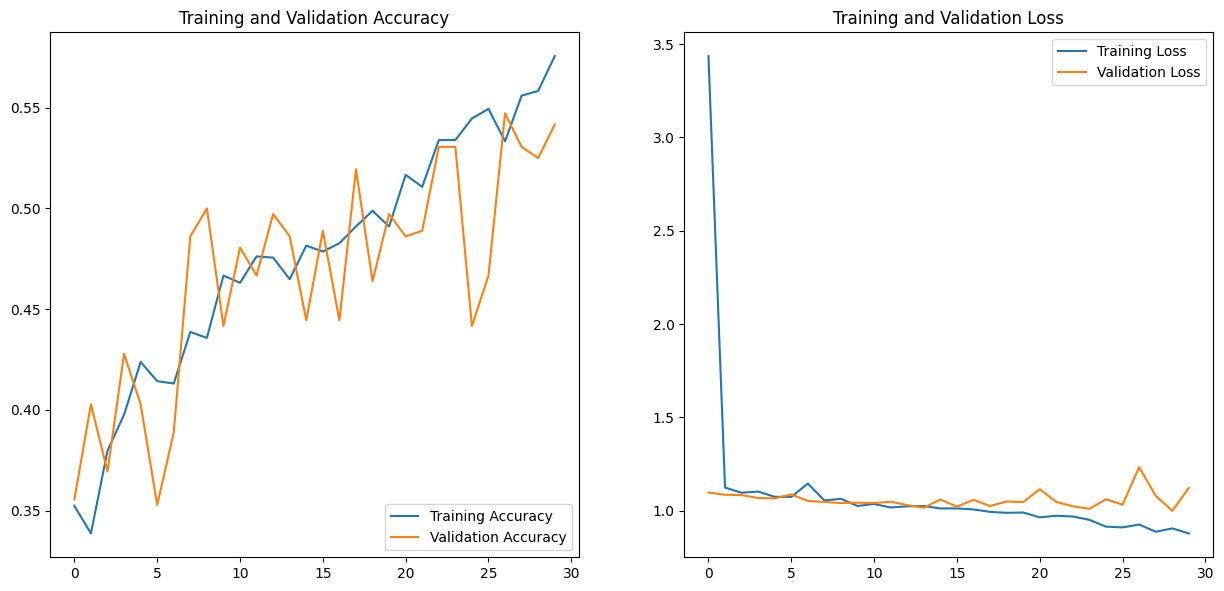

In [71]:
## PLottting the accuracy vs loss graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(30)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [72]:
#The training and Validation loss is almost same, but for the training and validation accuracy chart, 
#the validation accuracy falls down in the later epochs, this could be because we have only taken 200 images for processing.

In [73]:
resultDF = createResultDf("CNN",acc[-1],fcl_accuracy)

12/12 [==============================] - 0s 14ms/step


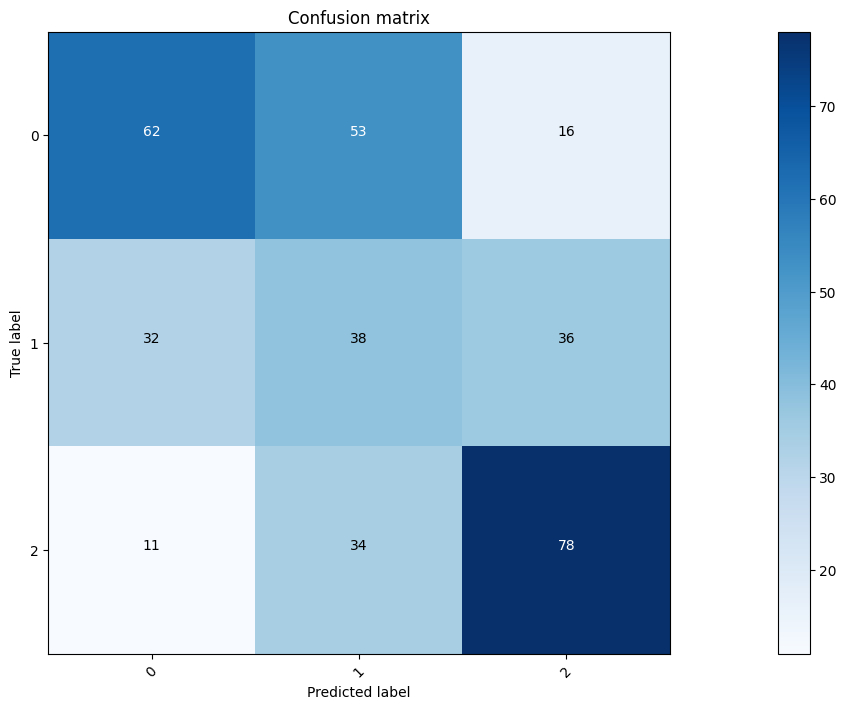

In [74]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))



In [75]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

reportData = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

#for data in reportData:
    #if(data == '-1' or data == '1'):
        #if(type(reportData[data]) is dict):
            #for subData in reportData[data]:
                #resultDF[data+"_"+subData] = reportData[data][subData]

report_DF=pd.DataFrame.from_dict(reportData)
report_DF

12/12 [==============================] - 0s 15ms/step


0           1           2  accuracy   macro avg  \
precision    0.590476    0.304000    0.600000  0.494444    0.498159   
recall       0.473282    0.358491    0.634146  0.494444    0.488640   
f1-score     0.525424    0.329004    0.616601  0.494444    0.490343   
support    131.000000  106.000000  123.000000  0.494444  360.000000   

           weighted avg  
precision      0.509379  
recall         0.494444  
f1-score       0.498741  
support      360.000000

In [76]:
## Creating a Copy
X_train1 = X_train.copy()
X_val1 = X_val.copy()
X_test1 = X_test.copy()

In [77]:
#CNN with Tranfer learning using VGG16

In [78]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

##VGGNet is a well-documented and globally used architecture for convolutional neural network
## Include_top=False to remove the classification layer that was trained on the ImageNet dataset and set the model as not trainable

base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)

In [79]:
## Adding two hidden later and one softmax layer as an output layer
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')


cnn_VGG16_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [80]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_VGG16_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## Early stopping whe validation accuracy does not change for 7 iteration 
es = EarlyStopping(monitor='val_accuracy', mode='auto', patience=7,  restore_best_weights=True)

#Trainign the model
history = cnn_VGG16_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val) ,callbacks=es)

Epoch 1/30
53/53 [==============================] - 9s 102ms/step - loss: 1.3597 - accuracy: 0.5476 - val_loss: 0.7089 - val_accuracy: 0.6083
Epoch 2/30
53/53 [==============================] - 3s 56ms/step - loss: 0.4515 - accuracy: 0.7167 - val_loss: 0.5413 - val_accuracy: 0.6167
Epoch 3/30
53/53 [==============================] - 3s 52ms/step - loss: 0.3052 - accuracy: 0.8196 - val_loss: 0.5657 - val_accuracy: 0.6167
Epoch 4/30
53/53 [==============================] - 3s 55ms/step - loss: 0.2240 - accuracy: 0.8893 - val_loss: 0.5937 - val_accuracy: 0.5889
Epoch 5/30
53/53 [==============================] - 3s 57ms/step - loss: 0.1534 - accuracy: 0.9393 - val_loss: 0.6608 - val_accuracy: 0.5972
Epoch 6/30
53/53 [==============================] - 3s 52ms/step - loss: 0.1029 - accuracy: 0.9685 - val_loss: 0.7386 - val_accuracy: 0.6000
Epoch 7/30
53/53 [==============================] - 3s 52ms/step - loss: 0.0631 - accuracy: 0.9929 - val_loss: 0.7440 - val_accuracy: 0.5694
Epoch 8/30
5

In [81]:
test_ds = preprocess_input(X_test1) 
fcl_loss, fcl_accuracy = cnn_VGG16_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

12/12 [==============================] - 1s 47ms/step - loss: 0.5137 - accuracy: 0.6583
Test loss: 0.5136998891830444
Test accuracy: 0.6583333611488342


In [82]:
## The Test accuracy score if 65% but the training accurayc is close to 100 , this model is overfitting

In [83]:
resultsDf1 = pd.concat([resultDF, createResultDf("CNN With VGG16",1.000,fcl_accuracy)])

In [88]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn_VGG16_model.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_testPred,axis = 1) 

reportData1 = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

#for data in reportData:
    #if(data == '-1' or data == '1'):
        #if(type(reportData[data]) is dict):
            #for subData in reportData[data]:
                #resultsDf1[data+"_"+subData] = reportData[data][subData]

report_DF=pd.DataFrame.from_dict(reportData1)
report_DF

12/12 [==============================] - 1s 45ms/step


0           1           2  accuracy   macro avg  \
precision    0.655629    0.537313    0.718310  0.658333    0.637084   
recall       0.755725    0.339623    0.829268  0.658333    0.641539   
f1-score     0.702128    0.416185    0.769811  0.658333    0.629375   
support    131.000000  106.000000  123.000000  0.658333  360.000000   

           weighted avg  
precision      0.642208  
recall         0.658333  
f1-score       0.641059  
support      360.000000

In [89]:
#CNN with ResNet50

In [90]:
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

resnet_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=X_train[0].shape)
#model = VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))

train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')

cnn_resnet_model = models.Sequential([
    resnet_base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [91]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_resnet_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
history =cnn_resnet_model.fit(train_ds, y_train, epochs=30, validation_data=(train_val_df,y_val))

Epoch 1/30
53/53 [==============================] - 53s 190ms/step - loss: 0.6531 - accuracy: 0.5339 - val_loss: 175.9638 - val_accuracy: 0.3222
Epoch 2/30
53/53 [==============================] - 7s 129ms/step - loss: 0.4698 - accuracy: 0.6625 - val_loss: 2.8296 - val_accuracy: 0.2000
Epoch 3/30
53/53 [==============================] - 7s 128ms/step - loss: 0.4248 - accuracy: 0.6911 - val_loss: 1.4540 - val_accuracy: 0.6250
Epoch 4/30
53/53 [==============================] - 7s 129ms/step - loss: 0.3923 - accuracy: 0.7149 - val_loss: 2.5291 - val_accuracy: 0.4722
Epoch 5/30
53/53 [==============================] - 7s 128ms/step - loss: 0.3727 - accuracy: 0.7464 - val_loss: 2.1161 - val_accuracy: 0.4472
Epoch 6/30
53/53 [==============================] - 8s 145ms/step - loss: 0.3364 - accuracy: 0.7798 - val_loss: 0.9536 - val_accuracy: 0.5778
Epoch 7/30
53/53 [==============================] - 7s 124ms/step - loss: 0.3067 - accuracy: 0.8024 - val_loss: 2.5316 - val_accuracy: 0.4444
Epo

In [92]:
fcl_loss, fcl_accuracy = cnn_resnet_model.evaluate(test_ds, y_test, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

12/12 [==============================] - 1s 41ms/step - loss: 1.4390 - accuracy: 0.6611
Test loss: 1.438999056816101
Test accuracy: 0.6611111164093018


In [94]:
## The accuracy of test score is 66% abut training accuracy is 99.8% again it might be again overfitting

In [95]:
resultsDf2 = pd.concat([resultsDf1, createResultDf("CNN With ResNet50",history.history['accuracy'][-1],fcl_accuracy)])

In [96]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

Y_truepred = np.argmax(y_test,axis = 1) 

Y_testPred = cnn_resnet_model.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_testPred,axis = 1) 

reportData2 = classification_report(Y_truepred, Y_pred_classes,output_dict=True)

#for data in reportData:
    #if(data == '-1' or data == '1'):
        #if(type(reportData[data]) is dict):
            #for subData in reportData[data]:
                #resultsDf2[data+"_"+subData] = reportData[data][subData]
report_DF=pd.DataFrame.from_dict(reportData2)
report_DF

12/12 [==============================] - 2s 39ms/step


0           1           2  accuracy   macro avg  \
precision    0.782178    0.534091    0.654971  0.661111    0.657080   
recall       0.603053    0.443396    0.910569  0.661111    0.652340   
f1-score     0.681034    0.484536    0.761905  0.661111    0.642492   
support    131.000000  106.000000  123.000000  0.661111  360.000000   

           weighted avg  
precision      0.665668  
recall         0.661111  
f1-score       0.650807  
support      360.000000

12/12 [==============================] - 0s 40ms/step


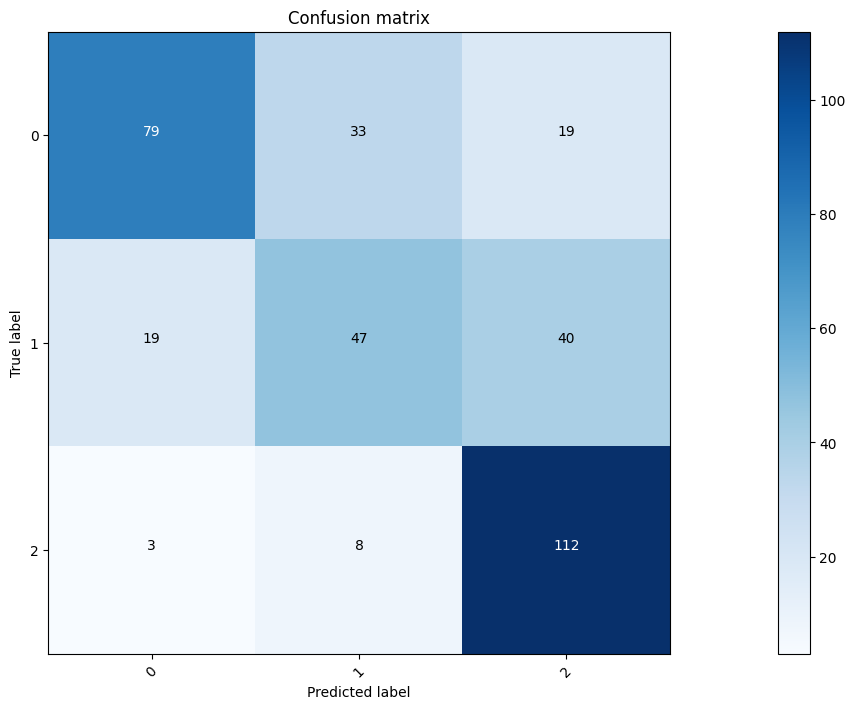

In [97]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
# Predict the values from the validation dataset
Y_pred = cnn_resnet_model.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

In [98]:
resultsDf2.head()

Method  accuracy  Test Score
0                CNN  0.575595    0.494444
0     CNN With VGG16  1.000000    0.658333
0  CNN With ResNet50  0.998810    0.661111

In [99]:
## with transfer learning we have the issue of overfitting, it does well in the training data set but little less in test dataset
## Without Transfer learning , the accuracy is not high but the model is not overfitting
## The precision is in the range of 0.5 to 0.7 for transfer learning models and it can be improved if we train our model with higher sample size more than 200 .  

In [100]:
#But since the colab is crashing when we try to take higher samples due to the system limitation  , 
#concluding that the transfer models when taken with higher samples sizes will improve the precision scores as requested in the question 